In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
df = pd.read_excel('/home/heemin/mv/dir/label.xlsx', engine='openpyxl')
df.head()

,file,label_JH,label_HM,label_YG
0,HJY_0,angry,Negative,Angry
1,HJY_1,angry,Negative,Angry
2,HJY_2,angry,Negative,Angry
3,HJY_60,angry,NaN,Angry
4,HJY_61,angry,NaN,Angry


In [4]:
df['label1'] = df['label_JH']
df['label2'] = df['label_HM']
df['label3'] = df['label_YG']

In [5]:
df['label_JH'].unique()

array(['angry', 'neutral', 'happy', nan, 'surprise'], dtype=object)

In [6]:
df['label_YG'].unique()

array(['Angry', 'Happy', 'Neutral', 'Surprise'], dtype=object)

In [7]:
df['label_HM'].unique()

array(['Negative', nan, 'Positive', 'Neutral'], dtype=object)

In [8]:
df.loc[df['label_JH']=='angry', 'label1'] = 'Negative'
df.loc[df['label_JH']=='surprise', 'label1'] = 'Positive'
df.loc[df['label_JH']=='happy', 'label1'] = 'Positive'
df.loc[df['label_JH']=='neutral', 'label1'] = 'Neutral'

df.loc[df['label_YG']=='Angry', 'label3'] = 'Negative'
df.loc[df['label_YG']=='Surprise', 'label3'] = 'Positive'
df.loc[df['label_YG']=='Happy', 'label3'] = 'Positive'

In [9]:
df2 = df[['file','label1','label2', 'label3']]
df2.isna().sum()

file        0
label1      3
label2    153
label3      0
dtype: int64

In [10]:
df2_dropna=df2.dropna()
df2_dropna['true'] = df2_dropna.mode(axis=1)[0]

/home/heemin/.pyenv/versions/3.6.8/envs/meta/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
len(df2_dropna)

476

In [12]:
# JWG drop
df2_dropna = df2_dropna[~df2_dropna['file'].str.contains('JWG', na = False)]
# df2_dropna = df2_dropna[~df2_dropna['file'].str.contains('LYG_2', na = False)]

In [13]:
df2_dropna.groupby('true').count()

,file,label1,label2,label3
true,,,,
Negative,35,35,35,35
Neutral,220,220,220,220
Positive,143,143,143,143


In [109]:
df2_dropna.to_excel('/home/heemin/mv/dir/label_true.xlsx')

In [110]:
len(df2_dropna)

398

## data crop

In [111]:
import os
import natsort

from collections import Counter

In [112]:
fl = os.listdir('/home/heemin/mv/dir/csv')

In [113]:
file_list = natsort.natsorted(fl)

In [114]:
drop_file =[]
for file in file_list:
    df1 = pd.read_csv('/home/heemin/mv/dir/csv/'+file)[['total_count', 'emotion']]
    if len(df1) < 25:
        drop_file.append(file)

In [115]:
true_label = pd.read_excel('/home/heemin/mv/dir/label_true.xlsx', engine='openpyxl')
drop_filename = []
for file in drop_file:
    drop_filename.append(file.split('.')[0])
drop_df = pd.DataFrame(drop_filename, columns=['file'])
drop_df['bad'] = 1
label1 = pd.merge(true_label, drop_df, how='left', on='file')
label2 = label1[label1['bad'].isnull()].iloc[:,1:-1]

In [116]:
label2

,file,label1,label2,label3,true
0,HJY_0,Negative,Negative,Negative,Negative
1,HJY_1,Negative,Negative,Negative,Negative
2,HJY_2,Negative,Negative,Negative,Negative
3,PSG_3,Negative,Negative,Negative,Negative
4,PSG_33,Negative,Negative,Negative,Negative
...,...,...,...,...,...
388,LTW_78,Neutral,Neutral,Neutral,Neutral
391,LTW_82,Neutral,Neutral,Neutral,Neutral
393,LTW_84,Neutral,Neutral,Neutral,Neutral
395,HJY_73,Neutral,Neutral,Positive,Neutral


In [117]:
label2['Neutral'] = 0
label2.loc[label2['true'] == 'Negative', 'Neutral'] = 1
label2.loc[label2['true'] == 'Positive', 'Neutral'] = 2
label2 = label2.reset_index()

In [118]:
label2.to_excel('/home/heemin/mv/dir/ll.xlsx')

frame to video crop이기 때문에 25frame 마다 crop 할 필요없이 1frame마다 crop하면 됨

In [119]:
for idx in range(len(label2)):
    file = label2['file'][idx]
    df1 = pd.read_csv('/home/heemin/mv/dir/csv/'+file+'.mp4.csv')[['total_count', 'emotion']]
    end_frame = int(df1['total_count'][-1:])
    df2 = pd.merge(pd.DataFrame([i for i in range(1, end_frame+1)], columns=['total_count']), df1, how='outer').fillna('Neutral')
    if label2['Neutral'][idx] == 1 or label2['Neutral'][idx] == 2:
        crop_frame_start = 0

        for i in range(end_frame):
            if df2['emotion'][i] == 'Neutral' or df2['emotion'][i] == 'none':
                crop_frame_start = i+1
            else:
                break
        crop_frame_end = end_frame

        reverse_df2 = pd.merge(pd.DataFrame([i for i in range(end_frame, -1, -1)], columns=['total_count']), df1, how='outer').fillna('Neutral')
        for i in range(end_frame):
            if reverse_df2['emotion'][i] == 'Neutral'or reverse_df2['emotion'][i] == 'none':
                crop_frame_end = reverse_df2['total_count'][i] - 1
            else:
                break
        if crop_frame_end == 0:
            crop_frame_start = 0
            crop_frame_end = end_frame

        df3 = df2[crop_frame_start:crop_frame_end]
    else:
        df3 = df2
    df3.to_csv('/home/heemin/mv/dir/csv_crop_video/'+file+'.mp4.csv')

In [120]:
emotion_dict = {'Angry':'Negative', 'Disgust':'Negative', 'Fear':'Negative', 'Happy':'Positive', 
    'Sad':'Negative', 'Suprise':'Positive', 'Neutral':'Neutral'}

threshold: 0.0  Neutral data: 18.71%  Negative data: 88.46%  Positive data: 88.00%  Total data: 51.70%


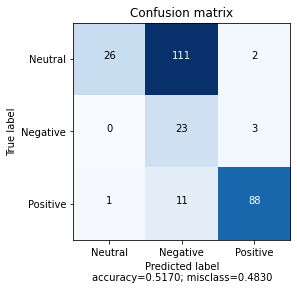

threshold: 0.05  Neutral data: 35.97%  Negative data: 88.46%  Positive data: 88.00%  Total data: 60.75%


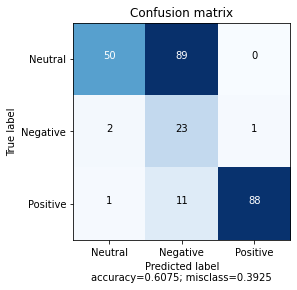

threshold: 0.1  Neutral data: 44.60%  Negative data: 80.77%  Positive data: 88.00%  Total data: 64.53%


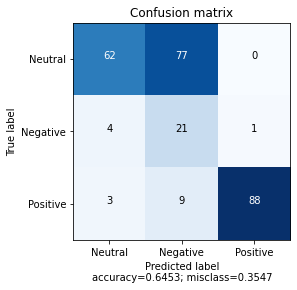

threshold: 0.15  Neutral data: 59.71%  Negative data: 69.23%  Positive data: 88.00%  Total data: 71.32%


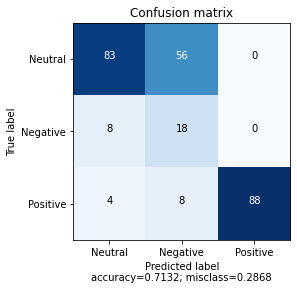

threshold: 0.2  Neutral data: 66.91%  Negative data: 50.00%  Positive data: 86.00%  Total data: 72.45%


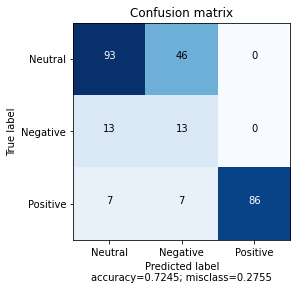

threshold: 0.25  Neutral data: 76.26%  Negative data: 30.77%  Positive data: 79.00%  Total data: 72.83%


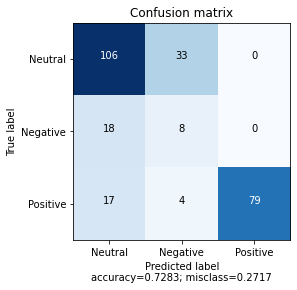

threshold: 0.3  Neutral data: 81.29%  Negative data: 23.08%  Positive data: 74.00%  Total data: 72.83%


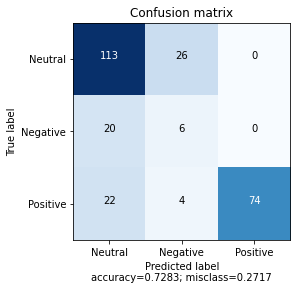

threshold: 0.35  Neutral data: 84.89%  Negative data: 7.69%  Positive data: 69.00%  Total data: 71.32%


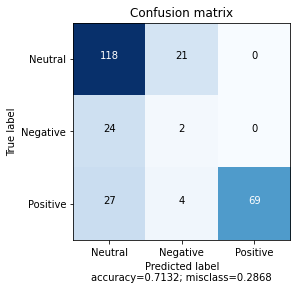

threshold: 0.4  Neutral data: 87.77%  Negative data: 3.85%  Positive data: 65.00%  Total data: 70.94%


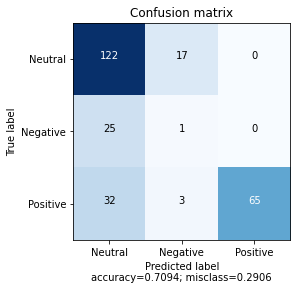

threshold: 0.45  Neutral data: 94.96%  Negative data: 3.85%  Positive data: 62.00%  Total data: 73.58%


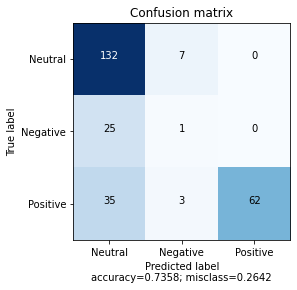

threshold: 0.5  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


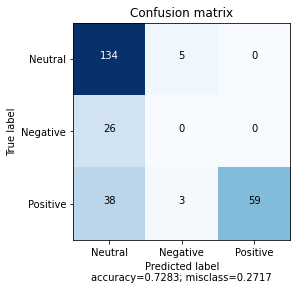

threshold: 0.55  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


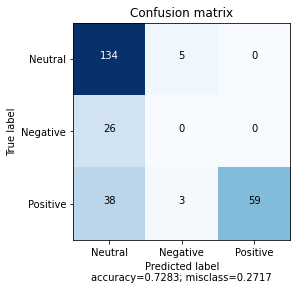

threshold: 0.6  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


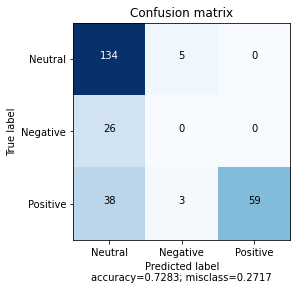

threshold: 0.65  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


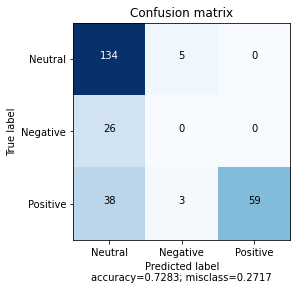

threshold: 0.7  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


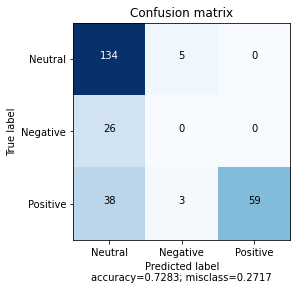

threshold: 0.75  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


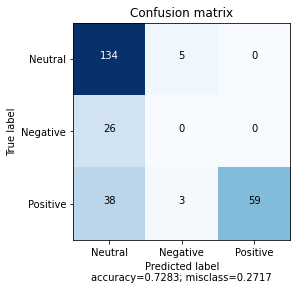

threshold: 0.8  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


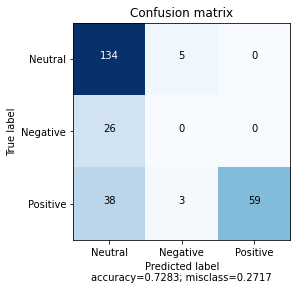

threshold: 0.85  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


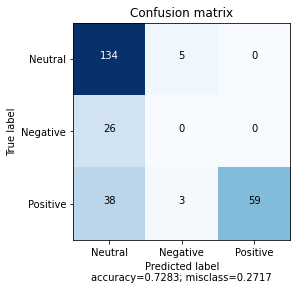

threshold: 0.9  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


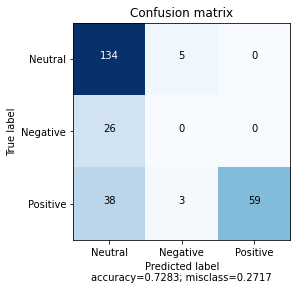

threshold: 0.95  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 59.00%  Total data: 72.83%


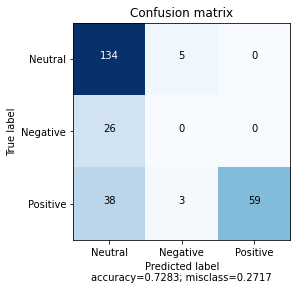

In [121]:
import copy
result = []
for thre in range(0, 100, 5):
    threshold = thre / 100
    n_total = 0
    n_correct = 0
    h_total = 0
    h_correct = 0
    e_total = 0
    e_correct = 0
    # threshold = 0.275
    bad_data = []
    cf_matrix = np.array([[0,0,0],
                        [0,0,0],
                        [0,0,0]])
    #           Neutral , Negative , Positive
    # Neutral   [0][0]     [0][1]     [0][2]
    # Negative  [1][0]     [1][1]     [1][2]
    # Positive  [2][0]     [2][1]     [2][2]
    for i in range(len(label2)):
        file = label2['file'][i]
        df = pd.read_csv('/home/heemin/mv/dir/csv_crop_video/'+file+'.mp4.csv', index_col=0)
        label = label2.loc[label2['file'] == file]['true'][i]

        if label2['Neutral'][i] == 0:
            l1 = df['total_count'].tolist()
            l2 = df['emotion'].tolist()
            df1 = pd.DataFrame([l1,l2]).T
            df1['index'] = df1[0]
            a = list(range(l1[-1]+1))
            index_df = pd.DataFrame(a, columns=['index'])
            df2 = pd.merge(index_df, df1, how="outer")
            df2 = df2.fillna('Neutral')
            emolist = df2[1].to_list()
            emocount = Counter(emolist)
            top3 = emocount.most_common(n=3)
            l3 = []


            total_len = len(df2)
            p10_len = int(total_len * threshold)
            # print(file, total_len, threshold, p10_len, top3)

            if top3[0][0] == 'none':
                if len(top3) == 1:
                    l3.append('Neutral')
                elif top3[1][0] == 'Neutral':
                    if len(top3) == 3:
                        if top3[2][1] >= p10_len:
                            l3.append(top3[2][0])
                        else:
                            l3.append(top3[1][0])
                    else:
                        l3.append(top3[1][0])
            elif top3[0][0] == 'Neutral':
                if len(top3) == 1:
                    l3.append('Neutral')
                elif top3[1][0] == 'none':
                    if len(top3) == 2: 
                        l3.append('Neutral')
                    else:
                        if top3[2][1] >= p10_len:
                            l3.append(top3[2][0])
                        else:
                            l3.append(top3[0][0])
                else:
                    if top3[1][1] >= p10_len:
                        l3.append(top3[1][0])
                    else:
                        l3.append(top3[0][0])
            else:
                l3.append(top3[0][0])
            for emotion in l3:
                n_total+=1
                if emotion_dict[emotion] == label:
                    cf_matrix[0][0] += 1
                    n_correct += 1
                else:
                    if emotion_dict[emotion] == 'Negative':
                        cf_matrix[0][1] += 1
                    elif emotion_dict[emotion] == 'Positive':
                        cf_matrix[0][2] += 1
                    bad_data.append([file, emotion, label])
                # print(file, emotion, label, emotion_dict[emotion], label)
        
        elif label2['Neutral'][i] == 1:
            l1 = df['total_count'].tolist()
            l2 = df['emotion'].tolist()
            df1 = pd.DataFrame([l1,l2]).T
            df1['index'] = df1[0]
            a = list(range(l1[-1]+1))
            index_df = pd.DataFrame(a, columns=['index'])
            df2 = pd.merge(index_df, df1, how="outer")
            df2 = df2.fillna('Neutral')
            emolist = df2[1].to_list()
            emocount = Counter(emolist)
            top3 = emocount.most_common(n=3)
            l3 = []


            total_len = len(df2)
            p10_len = int(total_len * threshold)

            if top3[0][0] == 'none':
                if len(top3) == 1:
                    l3.append('Neutral')
                elif top3[1][0] == 'Neutral':
                    if len(top3) == 3:
                        if top3[2][1] >= p10_len:
                            l3.append(top3[2][0])
                        else:
                            l3.append(top3[1][0])
                    else:
                        l3.append(top3[1][0])
            elif top3[0][0] == 'Neutral':
                if len(top3) == 1:
                    l3.append('Neutral')
                elif top3[1][0] == 'none':
                    if len(top3) == 2: 
                        l3.append('Neutral')
                    else:
                        if top3[2][1] >= p10_len:
                            l3.append(top3[2][0])
                        else:
                            l3.append(top3[0][0])
                else:
                    if top3[1][1] >= p10_len:
                        l3.append(top3[1][0])
                    else:
                        l3.append(top3[0][0])
            else:
                l3.append(top3[0][0])
            for emotion in l3:
                e_total+=1
                if emotion_dict[emotion] == label:
                    cf_matrix[1][1] += 1
                    e_correct += 1
                else:
                    if emotion_dict[emotion] == 'Neutral':
                        cf_matrix[1][0] += 1
                    elif emotion_dict[emotion] == 'Positive':
                        cf_matrix[1][2] += 1
                    bad_data.append([file, emotion, label])
                # print(file, emotion, label, emotion_dict[emotion], label)

        elif label2['Neutral'][i] == 2:
            l1 = df['total_count'].tolist()
            l2 = df['emotion'].tolist()
            df1 = pd.DataFrame([l1,l2]).T
            df1['index'] = df1[0]
            a = list(range(l1[-1]+1))
            index_df = pd.DataFrame(a, columns=['index'])
            df2 = pd.merge(index_df, df1, how="outer")
            df2 = df2.fillna('Neutral')
            emolist = df2[1].to_list()
            emocount = Counter(emolist)
            top3 = emocount.most_common(n=3)
            l3 = []


            total_len = len(df2)
            p10_len = int(total_len * threshold)

            if top3[0][0] == 'none':
                if len(top3) == 1:
                    l3.append('Neutral')
                elif top3[1][0] == 'Neutral':
                    if len(top3) == 3:
                        if top3[2][1] >= p10_len:
                            l3.append(top3[2][0])
                        else:
                            l3.append(top3[1][0])
                    else:
                        l3.append(top3[1][0])
            elif top3[0][0] == 'Neutral':
                if len(top3) == 1:
                    l3.append('Neutral')
                elif top3[1][0] == 'none':
                    if len(top3) == 2: 
                        l3.append('Neutral')
                    else:
                        if top3[2][1] >= p10_len:
                            l3.append(top3[2][0])
                        else:
                            l3.append(top3[0][0])
                else:
                    if top3[1][1] >= p10_len:
                        l3.append(top3[1][0])
                    else:
                        l3.append(top3[0][0])
            else:
                l3.append(top3[0][0])
            for emotion in l3:
                h_total+=1
                if emotion_dict[emotion] == label:
                    h_correct += 1
                    cf_matrix[2][2] += 1
                else:
                    if emotion_dict[emotion] == 'Neutral':
                        cf_matrix[2][0] += 1
                    elif emotion_dict[emotion] == 'Negative':
                        cf_matrix[2][1] += 1
                    bad_data.append([file, emotion, label])
                # print(file, emotion, label, emotion_dict[emotion], label)
    if thre == 15:
        gg = copy.deepcopy(bad_data)
        
    n_acc = n_correct / n_total
    h_acc = h_correct / h_total
    e_acc = e_correct / e_total
    acc = (n_correct+h_correct+e_correct) / (n_total+h_total+e_total)
    print(f'threshold: {threshold}  Neutral data: {n_acc*100:0.2f}%  Negative data: {e_acc*100:0.2f}%  Positive data: {h_acc*100:0.2f}%  Total data: {acc*100:0.2f}%')
    plot_confusion_matrix(cf_matrix, target_names=['Neutral', 'Negative', 'Positive'], normalize=False)
    result.append([threshold, acc, n_acc, e_acc, h_acc])

In [94]:
pd.DataFrame(result, columns=['Threshold', 'Accuracy', 'Neutral', 'Negative', 'Positive']).to_excel('/home/heemin/mv/dir/threshold.xlsx')

In [124]:
pd.DataFrame(gg, columns=['file', 'pred', 'label']).to_excel('/home/heemin/mv/dir/bad.xlsx')
gg

[['HJY_0', 'Neutral', 'Negative'],
 ['PSG_33', 'Neutral', 'Negative'],
 ['PSG_38', 'Neutral', 'Negative'],
 ['LYG_2_2', 'Neutral', 'Negative'],
 ['LYG_2_8', 'Neutral', 'Negative'],
 ['LYG_2_14', 'Neutral', 'Negative'],
 ['LYG_2_17', 'Neutral', 'Negative'],
 ['LYG_2_41', 'Neutral', 'Negative'],
 ['LYG_0', 'Sad', 'Positive'],
 ['PSG_0', 'Angry', 'Positive'],
 ['LJH_53', 'Neutral', 'Positive'],
 ['LYG_2_34', 'Sad', 'Positive'],
 ['LYG_2_44', 'Angry', 'Positive'],
 ['LYG_2_45', 'Sad', 'Positive'],
 ['LYG_2_46', 'Sad', 'Positive'],
 ['PJY_1', 'Angry', 'Positive'],
 ['PJY_2', 'Neutral', 'Positive'],
 ['PJY_3', 'Angry', 'Positive'],
 ['LTW_66', 'Neutral', 'Positive'],
 ['HJY_67', 'Sad', 'Neutral'],
 ['HJY_68', 'Sad', 'Neutral'],
 ['KSY_2', 'Sad', 'Neutral'],
 ['KSY_4', 'Sad', 'Neutral'],
 ['KSY_7', 'Sad', 'Neutral'],
 ['LYG_32', 'Sad', 'Neutral'],
 ['LYG_34', 'Sad', 'Neutral'],
 ['PSG_4', 'Sad', 'Neutral'],
 ['PSG_7', 'Sad', 'Neutral'],
 ['PSG_8', 'Angry', 'Neutral'],
 ['PSG_9', 'Angry', 'Neu

threshold: 0.95  Neutral data: 96.40%  Negative data: 0.00%  Positive data: 57.28%  Total data: 72.01%


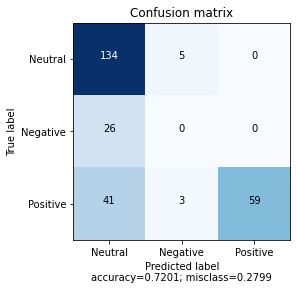

In [122]:
result = []
n_total = 0
n_correct = 0
h_total = 0
h_correct = 0
e_total = 0
e_correct = 0
# threshold = 0.275
bad_data = []
cf_matrix = np.array([[0,0,0],
                    [0,0,0],
                    [0,0,0]])
#           Neutral , Negative , Positive
# Neutral   [0][0]     [0][1]     [0][2]
# Negative  [1][0]     [1][1]     [1][2]
# Positive  [2][0]     [2][1]     [2][2]
for i in range(len(label2)):
    file = label2['file'][i]
    df = pd.read_csv('/home/heemin/mv/dir/csv_crop_video/'+file+'.mp4.csv', index_col=0)
    label = label2.loc[label2['file'] == file]['true'][i]

    if label2['Neutral'][i] == 0:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        df1['index'] = df1[0]
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a, columns=['index'])
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('Neutral')
        emolist = df2[1].to_list()
        emocount = Counter(emolist)
        top3 = emocount.most_common(n=3)
        l3 = []

        if top3[0][0] == 'none':
            l3.append('Neutral')
        else:
            l3.append(top3[0][0])
        for emotion in l3:
            n_total+=1
            if emotion_dict[emotion] == label:
                cf_matrix[0][0] += 1
                n_correct += 1
            else:
                if emotion_dict[emotion] == 'Negative':
                    cf_matrix[0][1] += 1
                elif emotion_dict[emotion] == 'Positive':
                    cf_matrix[0][2] += 1
                bad_data.append([file, emotion, label])
            # print(file, emotion, label, emotion_dict[emotion], label)
    
    elif label2['Neutral'][i] == 1:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        df1['index'] = df1[0]
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a, columns=['index'])
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('Neutral')
        emolist = df2[1].to_list()
        emocount = Counter(emolist)
        top3 = emocount.most_common(n=3)
        l3 = []

        if top3[0][0] == 'none':
            l3.append('Neutral')
        else:
            l3.append(top3[0][0])
        for emotion in l3:
            e_total+=1
            if emotion_dict[emotion] == label:
                cf_matrix[1][1] += 1
                e_correct += 1
            else:
                if emotion_dict[emotion] == 'Neutral':
                    cf_matrix[1][0] += 1
                elif emotion_dict[emotion] == 'Positive':
                    cf_matrix[1][2] += 1
                bad_data.append([file, emotion, label])
            # print(file, emotion, label, emotion_dict[emotion], label)

    elif label2['Neutral'][i] == 2:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        df1['index'] = df1[0]
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a, columns=['index'])
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('Neutral')
        emolist = df2[1].to_list()
        emocount = Counter(emolist)
        top3 = emocount.most_common(n=3)
        l3 = []


        if top3[0][0] == 'none':
            l3.append('Neutral')
        else:
            l3.append(top3[0][0])
            
        for emotion in l3:
            h_total+=1
            if emotion_dict[emotion] == label:
                h_correct += 1
                cf_matrix[2][2] += 1
            else:
                if emotion_dict[emotion] == 'Neutral':
                    cf_matrix[2][0] += 1
                elif emotion_dict[emotion] == 'Negative':
                    cf_matrix[2][1] += 1
                bad_data.append([file, emotion, label])
            # print(file, emotion, label, emotion_dict[emotion], label)

    
n_acc = n_correct / n_total
h_acc = h_correct / h_total
e_acc = e_correct / e_total
acc = (n_correct+h_correct+e_correct) / (n_total+h_total+e_total)
print(f'threshold: {threshold}  Neutral data: {n_acc*100:0.2f}%  Negative data: {e_acc*100:0.2f}%  Positive data: {h_acc*100:0.2f}%  Total data: {acc*100:0.2f}%')
plot_confusion_matrix(cf_matrix, target_names=['Neutral', 'Negative', 'Positive'], normalize=False)
result.append([threshold, acc, n_acc, e_acc, h_acc])

In [36]:
cf_matrix

array([[134,   5,   0],
       [  7,   0,   0],
       [ 35,   1,  58]])

In [44]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

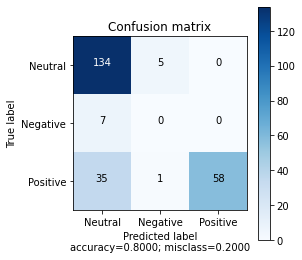

In [47]:
plot_confusion_matrix(cf_matrix, target_names=['Neutral', 'Negative', 'Positive'], normalize=False)

In [125]:
n_total = 0
n_correct = 0
e_total = 0
e_correct = 0
theshold = 0.275
bad_data = []
for i in range(len(label2)):
    file = label2['file'][i]
    df = pd.read_csv('/Users/heemin/Documents/DHLab/mv/project/csv_crop_video/'+file+'.mp4.csv', index_col=0)
    label = label2.loc[label2['file'] == file]['true'][i]

    if label2['Neutral'][i] == 0:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a)
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('none')
        emolist = df2[1].to_list()
        emocount = Counter(emolist)
        top3 = emocount.most_common(n=3)
        l3 = []


        total_len = len(l1)
        p10_len = int(total_len * theshold)

        if top3[0][0] == 'none':
            if len(top3) == 1:
                l3.append('Neutral')
            elif top3[1][0] == 'Neutral':
                if top3[2][1] >= p10_len:
                    l3.append(top3[2][0])
                else:
                    l3.append(top3[1][0])
        elif top3[0][0] == 'Neutral':
            if len(top3) == 1:
                l3.append('Neutral')
            elif top3[1][0] == 'none':
                if len(top3) == 2: 
                    l3.append('Neutral')
                else:
                    if top3[2][1] >= p10_len:
                        l3.append(top3[2][0])
                    else:
                        l3.append(top3[0][0])
            else:
                if top3[1][1] >= p10_len:
                    l3.append(top3[1][0])
                else:
                    l3.append(top3[0][0])

        else:
            l3.append(top3[0][0])
        for emotion in l3:
            e_total+=1
            if emotion_dict[emotion] == label:
                e_correct += 1
            else:
                bad_data.append([file, emotion, label])
            print(file, emotion, label)
    
    else:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a)
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('none')
        emolist = df2[1].to_list()
        emocount = Counter(emolist)
        top3 = emocount.most_common(n=3)
        l3 = []


        total_len = len(l1)
        p10_len = int(total_len * theshold)

        if top3[0][0] == 'none':
            if len(top3) == 1:
                l3.append('Neutral')
            elif top3[1][0] == 'Neutral':
                if top3[2][1] >= p10_len:
                    l3.append(top3[2][0])
                else:
                    l3.append(top3[1][0])
        elif top3[0][0] == 'Neutral':
            if len(top3) == 1:
                l3.append('Neutral')
            elif top3[1][0] == 'none':
                if len(top3) == 2: 
                    l3.append('Neutral')
                else:
                    if top3[2][1] >= p10_len:
                        l3.append(top3[2][0])
                    else:
                        l3.append(top3[0][0])
            else:
                if top3[1][1] >= p10_len:
                    l3.append(top3[1][0])
                else:
                    l3.append(top3[0][0])
        else:
            l3.append(top3[0][0])
        for emotion in l3:
            n_total+=1
            if emotion_dict[emotion] == label:
                n_correct += 1
            else:
                bad_data.append([file, emotion, label])
            print(file, emotion, label)
    
n_acc = n_correct / n_total
e_acc = e_correct / e_total
acc = (n_correct+e_correct) / (n_total+e_total)
print(f'Accuracy for Neutral data: {n_acc*100:0.2f}%\nAccuracy for Emotion data: {e_acc*100:0.2f}%\nAccuracy for Total data: {acc*100:0.2f}%\n')

HJY_0 Happy Negative
HJY_1 Neutral Negative
HJY_2 Neutral Negative
HJY_3 Neutral Neutral
HJY_4 Neutral Neutral
HJY_5 Neutral Positive
HJY_6 Happy Positive
HJY_7 Happy Positive
HJY_12 Neutral Neutral
HJY_14 Neutral Neutral
HJY_15 Neutral Neutral
HJY_16 Neutral Neutral
HJY_17 Neutral Neutral
HJY_18 Neutral Neutral
HJY_20 Neutral Neutral
HJY_22 Happy Positive
HJY_23 Happy Positive
HJY_24 Happy Positive
HJY_25 Happy Positive
HJY_27 Happy Positive
HJY_28 Happy Positive
HJY_29 Neutral Positive
HJY_30 Happy Positive
HJY_36 Neutral Neutral
HJY_40 Neutral Positive
HJY_41 Happy Positive
HJY_42 Happy Positive
HJY_58 Happy Positive
HJY_64 Happy Positive
HJY_65 Neutral Neutral
HJY_66 Neutral Neutral
HJY_67 Sad Neutral
HJY_68 Neutral Neutral
HJY_69 Neutral Neutral
HJY_70 Neutral Neutral
HJY_71 Neutral Neutral
HJY_72 Neutral Neutral
HJY_73 Neutral Neutral
KSY_2 Sad Neutral
KSY_4 Sad Neutral
KSY_5 Neutral Neutral
KSY_6 Neutral Neutral
KSY_7 Neutral Neutral
KSY_9 Neutral Neutral
KSY_10 Neutral Neutral


In [23]:
bd = pd.DataFrame(bad_data, columns=['file', 'emotion', 'label'])
bd[bd['label']=='Positive'][['emotion', 'label']].groupby('emotion').count().sort_values(by='label', ascending=False).reset_index()

,emotion,label
0,Angry,3
1,Neutral,3
2,Fear,1
3,Sad,1


In [24]:
bd[bd['label']=='Negative'][['emotion', 'label']].groupby('emotion').count().sort_values(by='label', ascending=False).reset_index()

,emotion,label
0,Neutral,2
1,Happy,1


In [25]:
bd[bd['label']=='Neutral'][['emotion', 'label']].groupby('emotion').count().sort_values(by='label', ascending=False).reset_index()

,emotion,label
0,Fear,2
1,Sad,2
2,Angry,1


In [26]:
bd[bd['label']=='Neutral'].to_excel('/Users/heemin/Documents/DHLab/mv/project/baddata_Neutral.xlsx')

In [ ]:
total = 0
correct = 0
e_total = 0
e_correct = 0
for i in range(len(label2)):
    file = label2['file'][i]
    df = pd.read_csv('/Users/heemin/Documents/DHLab/mv/project/csv_crop/'+file+'.mp4.csv', index_col=0)
    label = label2.loc[label2['file'] == file]['true'][i]

    if label2['Neutral'][i] == 0:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a)
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('none')
        l3 = []
        split = 0
        for i in range(len(df2)):
            if i % 25 == 0 and i != 0 or i == len(df2): # 25 frame 마다 연산
                emolist = df2[1][split:i].to_list()
                emocount = Counter(emolist)
                top3 = emocount.most_common(n=3)
                if len(top3) == 0: # top3 감정이 없음 = 해당 1초에 감정이 인식되지 않음
                    continue
                    l3.append([i, 'Neutral'])
                else:
                    if top3[0][0] == 'none': # top1이 none일때
                        if len(top3) == 1: # 1초 동안 none만 인식됐을때
                            continue
                            l3.append([i, 'Neutral']) # 중립감정으로 변경
                        else:
                            l3.append([i, top3[1][0]]) # none 외의 감정이 있을 경우, 그 감정으로
                    elif top3[0][0] == 'Neutral': # top1이 중립일때
                        if len(top3) == 1: # 1초 동안 중립만 인식됐을때
                            l3.append([i, top3[0][0]]) # 중립으로
                        elif top3[0][1] >= 2: # top2가 25프레임 중 3 이상일때 (25frame의 10%)
                            if top3[1][0] == 'none': # top2가 none이면
                                if len(top3) == 2: 
                                    continue
                                    l3.append([i, 'Neutral']) # 중립, none, 2개만 있을 경우, 중립으로 변경
                                else:
                                    l3.append([i, top3[2][0]]) # 그외의 감정이 있다면 그 감정으로
                            else:
                                l3.append([i, top3[1][0]]) # top2가 none이 아니면 그 감정으로
                        else: # 1초 동안 중립을 포함한 2개 이상의 감정을 인식하고, 25프레임 중 top2 감정이 3이하 일때
                            if top3[1][0] == 'none': # top2가 none 일 경우
                                if len(top3) == 2: # 중립과 none만 있다면 중립으로
                                    continue
                                    l3.append([i, 'Neutral'])
                                else: # 그외의 감정이 있다면 그 감정으로
                                    l3.append([i, top3[2][0]])
                            else: # 그 외는 첫 감정으로
                                l3.append([i, top3[0][0]])
                    else: # top1이 none 외의 감정일때 그 감정으로 인식한다.
                        l3.append([i, top3[0][0]])
                split+=25
        # pd.DataFrame(l3, columns=[['count','emotion']]).to_csv('/Users/heemin/Documents/DHLab/mv/project/dir/emotion_top3/'+j[1])
        for scound, emotion in l3:
            e_total+=1
            if emotion_dict[emotion] == label:
                e_correct += 1
            print(file, emotion, label)
        
    else:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a)
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('none')
        l3 = []
        split = 0
        for i in range(len(df2)):
            if i % 25 == 0 and i != 0 or i == len(df2): # 25 frame 마다 연산
                emolist = df2[1][split:i].to_list()
                emocount = Counter(emolist)
                top3 = emocount.most_common(n=3)
                if len(top3) == 0: # top3 감정이 없음 = 해당 1초에 감정이 인식되지 않음
                    l3.append([i, 'Neutral'])
                else:
                    if top3[0][0] == 'none': # top1이 none일때
                        if len(top3) == 1: # 1초 동안 none만 인식됐을때
                            l3.append([i, 'Neutral']) # 중립감정으로 변경
                    elif top3[0][0] == 'Neutral': # top1이 중립일때
                        if len(top3) == 1: # 1초 동안 중립만 인식됐을때
                            l3.append([i, top3[0][0]]) # 중립으로
                        elif top3[0][1] >= 2: # top2가 25프레임 중 3 이상일때 (25frame의 10%)
                            if top3[1][0] == 'none': # top2가 none이면
                                if len(top3) == 2: 
                                    l3.append([i, 'Neutral']) # 중립, none, 2개만 있을 경우, 중립으로 변경
                                else:
                                    l3.append([i, top3[2][0]]) # 그외의 감정이 있다면 그 감정으로
                            else:
                                l3.append([i, top3[1][0]]) # top2가 none이 아니면 그 감정으로
                        else: # 1초 동안 중립을 포함한 2개 이상의 감정을 인식하고, 25프레임 중 top2 감정이 3이하 일때
                            if top3[1][0] == 'none': # top2가 none 일 경우
                                l3.append([i, 'Neutral'])
                            else: # 그 외는 첫 감정으로
                                l3.append([i, top3[0][0]])
                    else: # top1이 none 외의 감정일때 그 감정으로 인식한다.
                        l3.append([i, top3[0][0]])
                split+=25
        # pd.DataFrame(l3, columns=[['count','emotion']]).to_csv('/Users/heemin/Documents/DHLab/mv/project/dir/emotion_top3/'+j[1])
        for scound, emotion in l3:
            total+=1
            if emotion_dict[emotion] == label:
                correct += 1
            print(file, emotion, label)
acc = correct / total
e_acc = e_correct / e_total

In [20]:
for idx in range(len(label2)):
    file = label2['file'][idx]
    df1 = pd.read_csv('/Users/heemin/Documents/DHLab/mv/project/csv/'+file+'.mp4.csv')[['total_count', 'emotion']]
    end_frame = int(df1['total_count'][-1:])
    df2 = pd.merge(pd.DataFrame([i for i in range(1, end_frame+1)], columns=['total_count']), df1, how='outer').fillna('Neutral')
    if label2['Neutral'][idx] == 0:
        split = 0
        frame2scound = []
        crop_frame_start = 0

        for i in range(1, end_frame+1):
            if i % 25 == 0 or i == end_frame+1:
                emolist = df2['emotion'][split:i].to_list()
                emocount = Counter(emolist)
                top3 = emocount.most_common(n=3)
                if len(top3) == 0: # top3 감정이 없음 = 해당 1초에 감정이 인식되지 않음
                    crop_frame_start = i
                elif len(top3) == 1:
                    if top3[0][0] == 'Neutral':
                        crop_frame_start = i
                    else:
                        continue
                else:
                    continue
                split += 25

        if end_frame%25 >0:
            r_end_frame = end_frame//25*25+25
        else:
            r_end_frame = end_frame//25*25
        crop_frame_end = r_end_frame
        reverse_df2 = pd.merge(pd.DataFrame([i for i in range(r_end_frame, -1, -1)], columns=['total_count']), df1, how='outer').fillna('Neutral')
        split = 0
        for i in range(1, end_frame+1):
            if i % 25 == 0 or i == end_frame+1:
                emolist = reverse_df2['emotion'][split:i].to_list()
                emocount = Counter(emolist)
                top3 = emocount.most_common(n=3)
                if len(top3) == 0: # top3 감정이 없음 = 해당 1초에 감정이 인식되지 않음
                    crop_frame_end = i
                elif len(top3) == 1:
                    if top3[0][0] == 'Neutral':
                        crop_frame_end = i
                split += 25
        if crop_frame_start == crop_frame_end:
            crop_frame_start = 0
            crop_frame_end = r_end_frame
        df3 = df2[crop_frame_start:crop_frame_end]
    else:
        df3 = df2
    df3.to_csv('/Users/heemin/Documents/DHLab/mv/project/csv_crop/'+file+'.mp4.csv')


In [21]:
reverse_df2.T

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
total_count,75,74,73,72,71,70,69,68,67,66,...,9,8,7,6,5,4,3,2,1,0
emotion,Neutral,Neutral,Neutral,Happy,Happy,Happy,Neutral,Neutral,Neutral,Neutral,...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral


In [22]:
emotion_dict = {'Angry':'Negative', 'Disgust':'Negative', 'Fear':'Negative', 'Happy':'Positive', 
    'Sad':'Negative', 'Suprise':'Positive', 'Neutral':'Neutral'}

In [110]:
pd.set_option('display.max_rows', None)
# pd.options.display.max_rows = 60

In [ ]:
total = 0
correct = 0
e_total = 0
e_correct = 0
for i in range(len(label2)):
    file = label2['file'][i]
    df = pd.read_csv('/Users/heemin/Documents/DHLab/mv/project/csv_crop/'+file+'.mp4.csv', index_col=0)
    label = label2.loc[label2['file'] == file]['true'][i]

    if label2['Neutral'][i] == 0:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a)
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('none')
        l3 = []
        split = 0
        for i in range(len(df2)):
            if i % 25 == 0 and i != 0 or i == len(df2): # 25 frame 마다 연산
                emolist = df2[1][split:i].to_list()
                emocount = Counter(emolist)
                top3 = emocount.most_common(n=3)
                if len(top3) == 0: # top3 감정이 없음 = 해당 1초에 감정이 인식되지 않음
                    continue
                    l3.append([i, 'Neutral'])
                else:
                    if top3[0][0] == 'none': # top1이 none일때
                        if len(top3) == 1: # 1초 동안 none만 인식됐을때
                            continue
                            l3.append([i, 'Neutral']) # 중립감정으로 변경
                        else:
                            l3.append([i, top3[1][0]]) # none 외의 감정이 있을 경우, 그 감정으로
                    elif top3[0][0] == 'Neutral': # top1이 중립일때
                        if len(top3) == 1: # 1초 동안 중립만 인식됐을때
                            l3.append([i, top3[0][0]]) # 중립으로
                        elif top3[0][1] >= 2: # top2가 25프레임 중 3 이상일때 (25frame의 10%)
                            if top3[1][0] == 'none': # top2가 none이면
                                if len(top3) == 2: 
                                    continue
                                    l3.append([i, 'Neutral']) # 중립, none, 2개만 있을 경우, 중립으로 변경
                                else:
                                    l3.append([i, top3[2][0]]) # 그외의 감정이 있다면 그 감정으로
                            else:
                                l3.append([i, top3[1][0]]) # top2가 none이 아니면 그 감정으로
                        else: # 1초 동안 중립을 포함한 2개 이상의 감정을 인식하고, 25프레임 중 top2 감정이 3이하 일때
                            if top3[1][0] == 'none': # top2가 none 일 경우
                                if len(top3) == 2: # 중립과 none만 있다면 중립으로
                                    continue
                                    l3.append([i, 'Neutral'])
                                else: # 그외의 감정이 있다면 그 감정으로
                                    l3.append([i, top3[2][0]])
                            else: # 그 외는 첫 감정으로
                                l3.append([i, top3[0][0]])
                    else: # top1이 none 외의 감정일때 그 감정으로 인식한다.
                        l3.append([i, top3[0][0]])
                split+=25
        # pd.DataFrame(l3, columns=[['count','emotion']]).to_csv('/Users/heemin/Documents/DHLab/mv/project/dir/emotion_top3/'+j[1])
        for scound, emotion in l3:
            e_total+=1
            if emotion_dict[emotion] == label:
                e_correct += 1
            print(file, emotion, label)
        
    else:
        l1 = df['total_count'].tolist()
        l2 = df['emotion'].tolist()
        df1 = pd.DataFrame([l1,l2]).T
        a = list(range(l1[-1]+1))
        index_df = pd.DataFrame(a)
        df2 = pd.merge(index_df, df1, how="outer")
        df2 = df2.fillna('none')
        l3 = []
        split = 0
        for i in range(len(df2)):
            if i % 25 == 0 and i != 0 or i == len(df2): # 25 frame 마다 연산
                emolist = df2[1][split:i].to_list()
                emocount = Counter(emolist)
                top3 = emocount.most_common(n=3)
                if len(top3) == 0: # top3 감정이 없음 = 해당 1초에 감정이 인식되지 않음
                    l3.append([i, 'Neutral'])
                else:
                    if top3[0][0] == 'none': # top1이 none일때
                        if len(top3) == 1: # 1초 동안 none만 인식됐을때
                            l3.append([i, 'Neutral']) # 중립감정으로 변경
                    elif top3[0][0] == 'Neutral': # top1이 중립일때
                        if len(top3) == 1: # 1초 동안 중립만 인식됐을때
                            l3.append([i, top3[0][0]]) # 중립으로
                        elif top3[0][1] >= 2: # top2가 25프레임 중 3 이상일때 (25frame의 10%)
                            if top3[1][0] == 'none': # top2가 none이면
                                if len(top3) == 2: 
                                    l3.append([i, 'Neutral']) # 중립, none, 2개만 있을 경우, 중립으로 변경
                                else:
                                    l3.append([i, top3[2][0]]) # 그외의 감정이 있다면 그 감정으로
                            else:
                                l3.append([i, top3[1][0]]) # top2가 none이 아니면 그 감정으로
                        else: # 1초 동안 중립을 포함한 2개 이상의 감정을 인식하고, 25프레임 중 top2 감정이 3이하 일때
                            if top3[1][0] == 'none': # top2가 none 일 경우
                                l3.append([i, 'Neutral'])
                            else: # 그 외는 첫 감정으로
                                l3.append([i, top3[0][0]])
                    else: # top1이 none 외의 감정일때 그 감정으로 인식한다.
                        l3.append([i, top3[0][0]])
                split+=25
        # pd.DataFrame(l3, columns=[['count','emotion']]).to_csv('/Users/heemin/Documents/DHLab/mv/project/dir/emotion_top3/'+j[1])
        for scound, emotion in l3:
            total+=1
            if emotion_dict[emotion] == label:
                correct += 1
            print(file, emotion, label)
acc = correct / total
e_acc = e_correct / e_total

In [392]:
e_acc

0.6993865030674846

In [393]:
e_total

652

In [394]:
e_correct

456

In [395]:
acc

0.359436045524036

In [396]:
correct

2116

In [397]:
total

5887

In [398]:
acc

0.359436045524036

In [399]:
correct

2116

In [400]:
total

5887

In [403]:
print(correct+e_correct)
print(total + e_total)
(correct+e_correct) /( total + e_total)

2572
6539


0.393332313809451